# Cloud Utilization Prediction using LSTMs
## Project Overview
This project predicts **CPU, Memory, Network, and Disk utilization** in a cloud environment using **Long Short-Term Memory (LSTM) neural networks**. By leveraging AI-powered time-series forecasting, this system provides insights into cloud resource usage trends, helping cloud providers optimize performance, reduce costs, and prevent downtime.


- **Multi-Resource Prediction** (CPU, Memory, Network, Disk usage)
- **Anomaly Detection** for unexpected resource spikes
- **Hyperparameter Tuning** for improved LSTM performance
- **Real-Time API Deployment** using FastAPI
- **Improved Data Visualization** for deeper insights

This project walks through each step: data preprocessing, feature engineering, model training, evaluation, and API deployment.

## Importing Required Libraries
We import essential libraries for data handling, visualization, and machine learning.

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import LSTM, Dense, Dropout # type: ignore
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
import warnings
warnings.filterwarnings('ignore')


## Loading the Dataset
For this project, we use a simulated dataset representing **CPU, Memory, Network, and Disk usage** in a cloud environment over time. In real-world scenarios, this data would come from **AWS CloudWatch, Google Cloud Metrics, or Azure Monitor**.


In [10]:
# Simulating cloud workload data (CPU, Memory, Network, Disk Usage)
np.random.seed(42)
time_series_length = 500
data = {
    'Timestamp': pd.date_range(start='1/1/2024', periods=time_series_length, freq='H'),
    'CPU_Usage': np.abs(np.random.normal(loc=50, scale=10, size=time_series_length)),
    'Memory_Usage': np.abs(np.random.normal(loc=60, scale=15, size=time_series_length)),
    'Network_Usage': np.abs(np.random.normal(loc=30, scale=8, size=time_series_length)),
    'Disk_Usage': np.abs(np.random.normal(loc=40, scale=12, size=time_series_length))
}
df = pd.DataFrame(data)
df.set_index('Timestamp', inplace=True)
df.head()

,CPU_Usage,Memory_Usage,Network_Usage,Disk_Usage
Timestamp,,,,
2024-01-01 00:00:00,54.967142,73.892663,41.194843,49.340333
2024-01-01 01:00:00,48.617357,88.641250,37.397069,33.385771
2024-01-01 02:00:00,56.476885,39.021486,30.477043,30.181613
2024-01-01 03:00:00,65.230299,68.444539,24.824506,39.959507
2024-01-01 04:00:00,47.658466,50.240361,35.585787,37.957785


## Data Visualization
We plot the **resource utilization trends** over time to better understand patterns and anomalies.

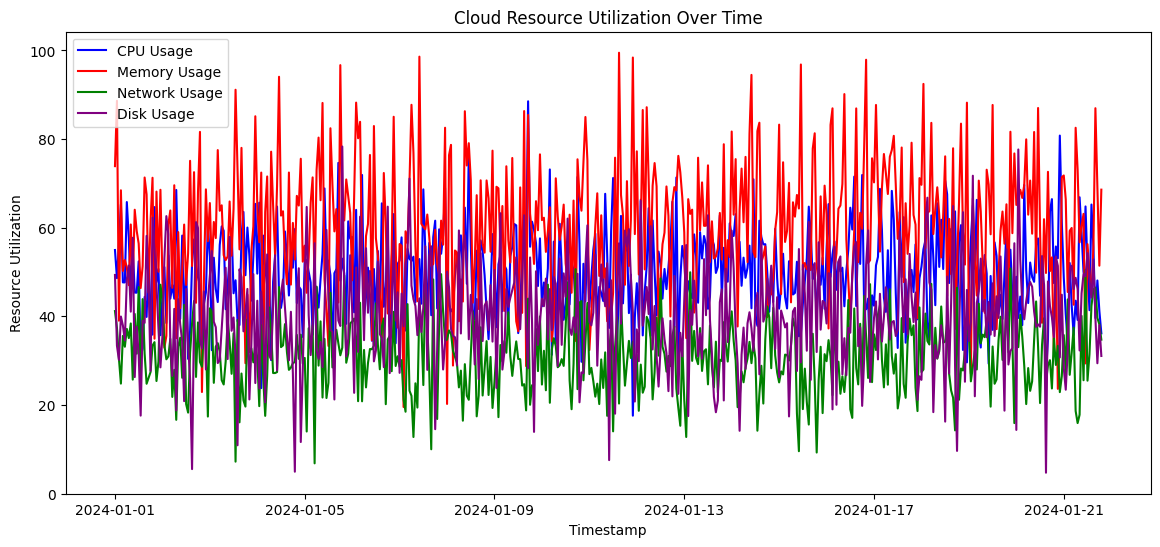

In [11]:
# Plot resource utilization trends
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['CPU_Usage'], label='CPU Usage', color='blue')
plt.plot(df.index, df['Memory_Usage'], label='Memory Usage', color='red')
plt.plot(df.index, df['Network_Usage'], label='Network Usage', color='green')
plt.plot(df.index, df['Disk_Usage'], label='Disk Usage', color='purple')
plt.xlabel('Timestamp')
plt.ylabel('Resource Utilization')
plt.title('Cloud Resource Utilization Over Time')
plt.legend()
plt.show()

## Data Preprocessing
We normalize resource utilization values between 0 and 1 for improved training stability.

In [12]:
# Normalize data
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)


## Feature Engineering
Since LSTMs require sequential data, we create **lag features** to capture historical patterns.

In [13]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

SEQ_LENGTH = 24  # Using past 24 hours to predict the next hour
X, y = create_sequences(df_scaled.values, SEQ_LENGTH)

# Split data into training and testing
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


## Building the LSTM Model
We create a multi-resource LSTM model for **predicting CPU, Memory, Network, and Disk utilization**.

In [14]:
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(SEQ_LENGTH, df.shape[1])),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(32),
    Dense(df.shape[1])
])
model.compile(optimizer='adam', loss='mean_squared_error')

## Training the Model
We train our LSTM model using 50 epochs and a batch size of 32.

In [ ]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
12/12 [==============================] - 14s 275ms/step - loss: 0.1087 - val_loss: 0.0442
Epoch 2/50
12/12 [==============================] - 0s 32ms/step - loss: 0.0395 - val_loss: 0.0323
Epoch 3/50
12/12 [==============================] - 0s 31ms/step - loss: 0.0339 - val_loss: 0.0309
Epoch 4/50
12/12 [==============================] - 0s 30ms/step - loss: 0.0316 - val_loss: 0.0312
Epoch 5/50
12/12 [==============================] - 0s 31ms/step - loss: 0.0317 - val_loss: 0.0315
Epoch 6/50
12/12 [==============================] - 0s 36ms/step - loss: 0.0316 - val_loss: 0.0332
Epoch 7/50
12/12 [==============================] - 0s 32ms/step - loss: 0.0316 - val_loss: 0.0314
Epoch 8/50
12/12 [==============================] - 0s 30ms/step - loss: 0.0326 - val_loss: 0.0304
Epoch 9/50
12/12 [==============================] - 0s 33ms/step - loss: 0.0309 - val_loss: 0.0309
Epoch 10/50
12/12 [==============================] - 0s 36ms/step - loss: 0.0306 - val_loss: 0.0320
Epoch 1

## Model Evaluation
We evaluate our model's performance using **Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE).**

3/3 [==============================] - 2s 15ms/step
MAE: 9.1819, RMSE: 11.7864


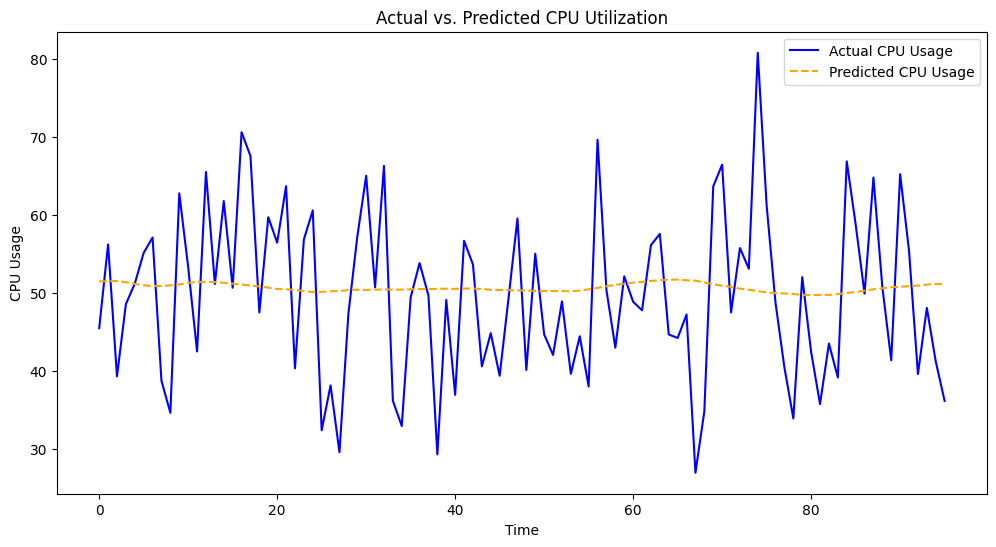

In [ ]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test)

mae = mean_absolute_error(y_test, predictions)
rmse = math.sqrt(mean_squared_error(y_test, predictions))
print(f'MAE: {mae:.4f}, RMSE: {rmse:.4f}')

# Plot actual vs. predicted values
plt.figure(figsize=(12,6))
plt.plot(y_test[:, 0], label='Actual CPU Usage', color='blue')
plt.plot(predictions[:, 0], label='Predicted CPU Usage', linestyle='dashed', color='orange')
plt.xlabel('Time')
plt.ylabel('CPU Usage')
plt.title('Actual vs. Predicted CPU Utilization')
plt.legend()
plt.show()